In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[-100, 600, -100, 600],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)


Now create the dipole model that will be used to generate the data.

In [3]:
sourcers1 = 7
sourcers2 = 7
np.random.seed(2)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-20]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(np.shape(dipole_moments))
print(np.shape(dipole_coordinates))



(15, 3)
(3, 15)


In [4]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 1.295 1.286 1.276 1.267 ... 12.43 12.3 12.18 12.05

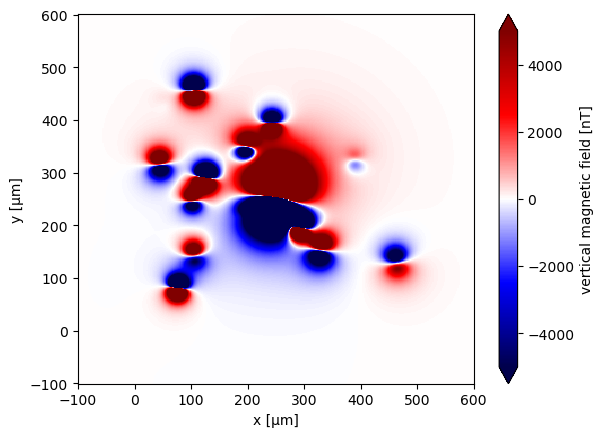

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [6]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

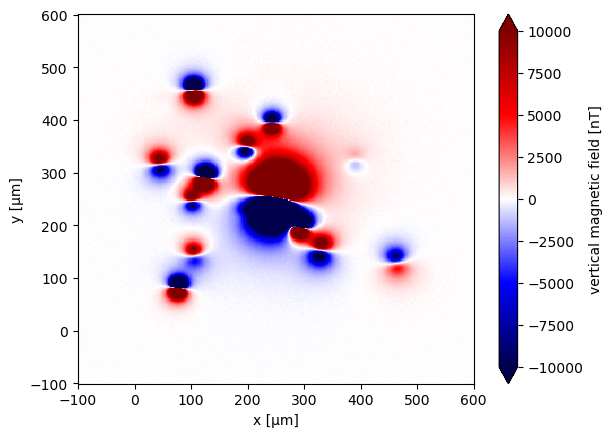

In [7]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [8]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8.119 8.97 9.577 8.5 ... 4.794 4.358 5.318 6.993

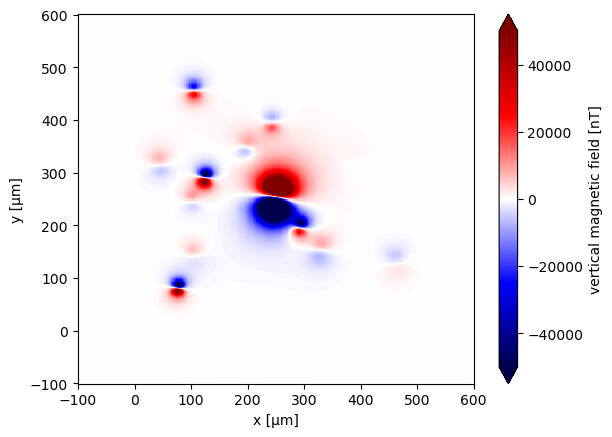

In [9]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [10]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8.119 8.97 9.577 8.5 ... 4.794 4.358 5.318 6.993
    tga      (y, x) float64 0.5436 0.505 1.164 1.305 ... 1.196 1.69 1.264 0.8729
    x_deriv  (y, x) float64 0.4255 0.3645 -0.1177 ... 0.1309 0.6587 0.8375
    y_deriv  (y, x) float64 -0.276 -0.3295 -0.3389 ... -0.5655 -0.1729 0.03741
    z_deriv  (y, x) float64 -0.1957 -0.1164 -1.107 ... 1.587 1.065 0.2431

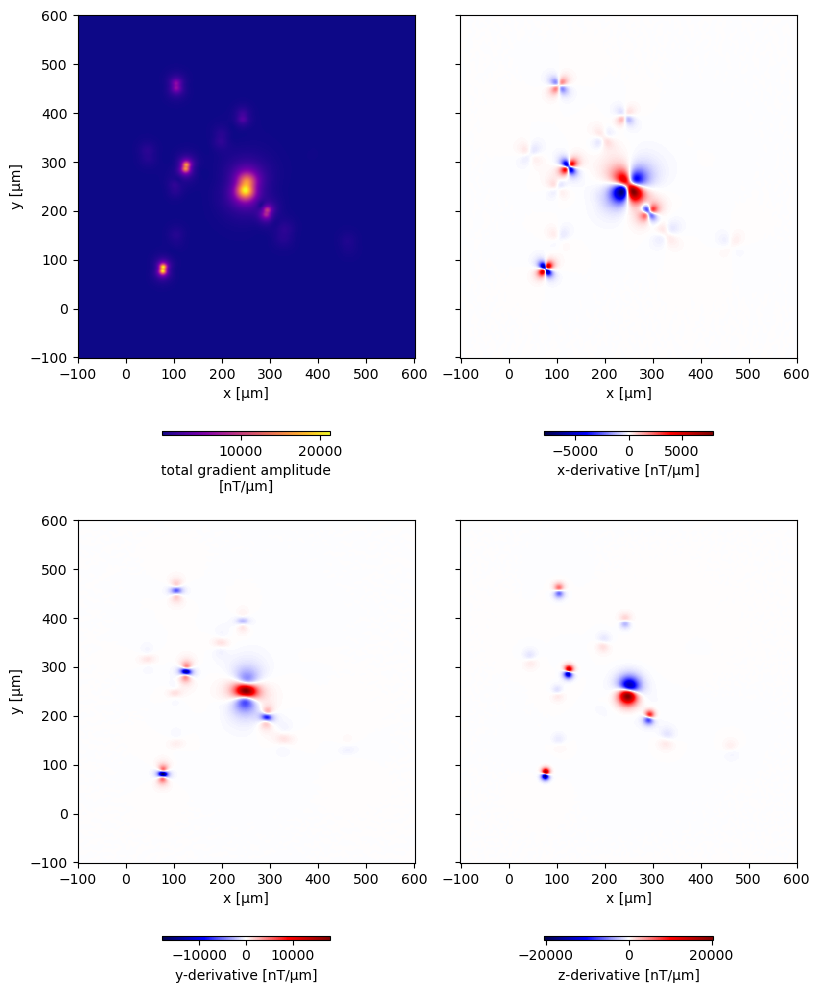

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [12]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (0.5, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

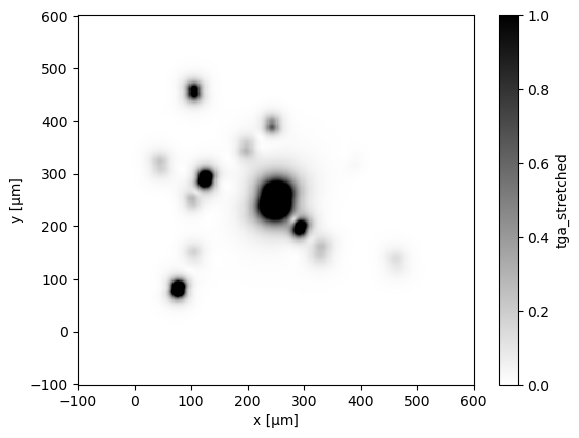

In [13]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [14]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.5,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [15]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  13


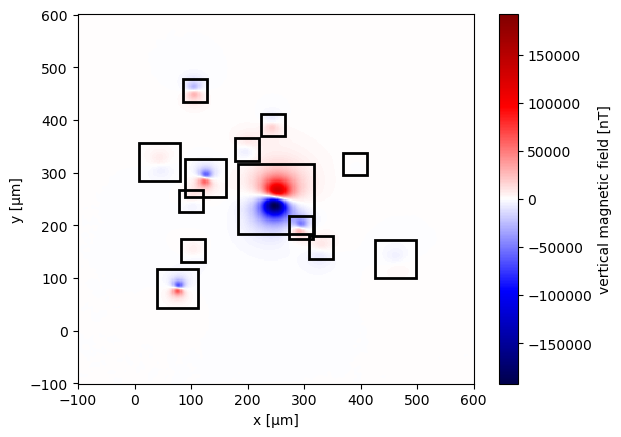

In [16]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [17]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False #r2 < 0.85 # False  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.9705065793586737 and SNR: 15.313058456016018 | -19.25796642657873
R²: 0.989352265883164 and SNR: 19.802514735502324 | -3.752817896610827
R²: 0.9979299181860241 and SNR: 26.85861352875827 | -1.600488536586098
R²: 0.9997369095685845 and SNR: 35.79994525790711 | -5.70841717366843
R²: 0.9302145052188184 and SNR: 11.731354283189173 | -7.218112820181147
R²: 0.987756849586371 and SNR: 19.126015790334666 | -8.7060407088076
R²: 0.5837437793476028 and SNR: 3.808236751706846 | -10.896948228793674
R²: 0.9911163674340573 and SNR: 20.52442128162515 | -13.374041280469624
R²: 0.856489713903732 and SNR: 8.553246798863778 | -16.677354256735377
R²: 0.9753100041987317 and SNR: 16.112004294713852 | -17.18230910366251
R²: 0.9943652523140729 and SNR: 22.759549160177226 | -15.559648827618332
R²: 0.9998048511328386 and SNR: 37.41791142869994 | -17.664827840602204
R²: 0.3628170407019444 and SNR: 2.0151685473803287 | -14.58066305274014

Dipole moments estimated: 13


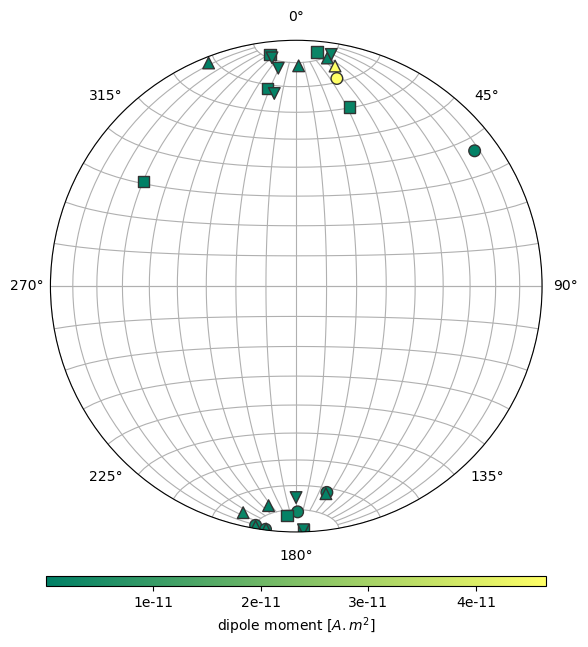

In [18]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

In [19]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.74203357,  0.2471821 ,  0.39951146,  0.29158283, -1.21811282,
       -0.70604071,  2.10305177,  0.62595872, -6.67735426, -0.1823091 ,
       -0.55964883,  0.33517216,  1.41933695])

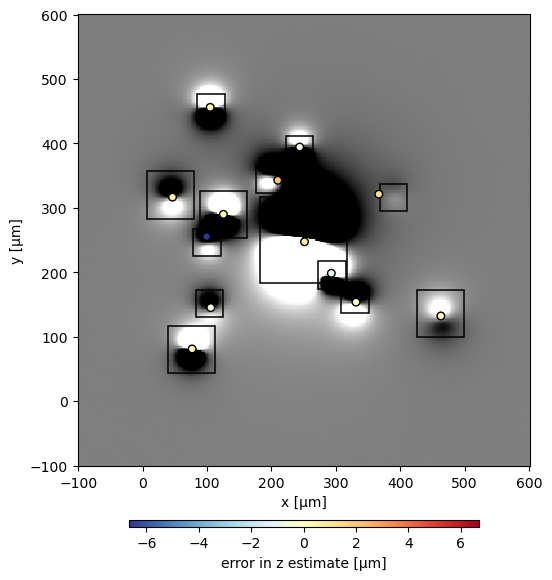

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [21]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 15.030579201919927 ± 0.112
Declination: 10.0 | 11.067700890093578 ± 0.159
Amplitude  : 5.000000e-11 | 4.654889e-11 ± 1.2e-13
R²   : 0.97051 
SNR  : 15.31306 
Direction Misfit  : 5.14° 
Magnetic Moment Misfit  : 6.90 %

Inclination: 0.9815597208941573 | 1.484395866672319 ± 0.114
Declination: -170.40097014953832 | -170.35816741608033 ± 0.161
Amplitude  : 1.911519e-12 | 1.863029e-12 ± 5.2e-15
R²   : 0.98935 
SNR  : 19.80251 
Direction Misfit  : 0.50° 
Magnetic Moment Misfit  : 2.54 %

Inclination: 0.5082551779939194 | 0.324583733849858 ± 0.050
Declination: -172.92622171639294 | -172.79987433151777 ± 0.071
Amplitude  : 1.326680e-12 | 1.243963e-12 ± 1.5e-15
R²   : 0.99793 
SNR  : 26.85861 
Direction Misfit  : 0.22° 
Magnetic Moment Misfit  : 6.23 %

Inclination: -0.9792030225966605 | -0.9372028484924319 ± 0.030
Declination: 178.3075852641996 | 178.268665744124 ± 0.044
Amplitude  : 1.327175e-12 | 1.275845e-12 ± 9.9e-16
R²   : 0.99974 
SNR  : 35.79995 
Direction Misfit  : 

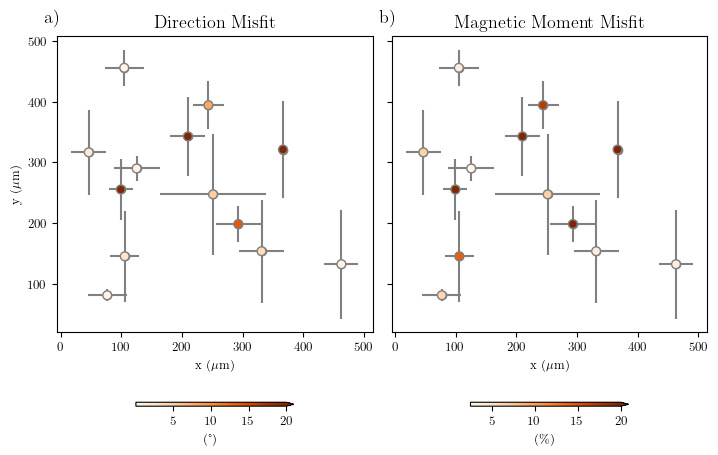

In [22]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
  
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    plt.show()


# All sources Linear Problem

In [23]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []


for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])

R²: 0.9705065793586737 and SNR: 15.313058456016018 | -19.25796642657873
R²: 0.989352265883164 and SNR: 19.802514735502324 | -3.752817896610827
R²: 0.9979299181860241 and SNR: 26.85861352875827 | -1.600488536586098
R²: 0.9997369095685845 and SNR: 35.79994525790711 | -5.70841717366843
R²: 0.9302145052188184 and SNR: 11.731354283189173 | -7.218112820181147
R²: 0.987756849586371 and SNR: 19.126015790334666 | -8.7060407088076
R²: 0.5837437793476028 and SNR: 3.808236751706846 | -10.896948228793674
R²: 0.9911163674340573 and SNR: 20.52442128162515 | -13.374041280469624
R²: 0.856489713903732 and SNR: 8.553246798863778 | -16.677354256735377
R²: 0.9753100041987317 and SNR: 16.112004294713852 | -17.18230910366251
R²: 0.9943652523140729 and SNR: 22.759549160177226 | -15.559648827618332
R²: 0.9998048511328386 and SNR: 37.41791142869994 | -17.664827840602204
R²: 0.3628170407019444 and SNR: 2.0151685473803287 | -14.58066305274014


In [24]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)


for window in windows:
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values #- base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.970537143930016 and SNR: 15.31342005840875 | -19.25796642657873


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9877445627009311 and SNR: 19.56240562553162 | -3.7949983325705485


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.997539176907998 and SNR: 26.9222518873718 | -1.5999019653505684


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997335629933969 and SNR: 35.759807606849485 | -5.694374131296717


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9908080973066407 and SNR: 20.509228637569198 | -5.832764533562917


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.985929706328038 and SNR: 19.605710551300415 | -8.007093269146738


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9819287150188148 and SNR: 17.662870078315155 | -12.310421130421048


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9982533625057944 and SNR: 27.85041718180013 | -13.589314418460187


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9990933439225016 and SNR: 30.44389141932434 | -9.886708687161752


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9984519503540499 and SNR: 28.13097258788577 | -16.672337088829888


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995010715133644 and SNR: 33.50250603712099 | -14.701217079283529


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995826390454418 and SNR: 36.81985339508102 | -17.870133782992774


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9873869463667599 and SNR: 19.80661934273159 | -16.16159292382744


In [25]:
# print(data_copy)
# print(data)

In [26]:
all_coordinates = [x_concat, y_concat, z_concat]

np.shape(all_coordinates)

df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat})#.set_index(['z'])

df['bz']
# ds = df.to_xarray()

# ds

0       -2906.877368
1       -3129.450757
2       -3367.259755
3       -3620.133445
4       -3889.457042
            ...     
13488     368.905544
13489     326.129671
13490     283.587240
13491     243.779167
13492     207.977596
Name: bz, Length: 13493, dtype: float64

In [27]:
all_positions = np.array([xc_concat, yc_concat, zc_concat])
print(all_positions)

[[251.37778286 125.36618447  76.93930914 104.99481711 292.01787545
  244.14842208 199.96017923  45.62357504 101.68358938 329.70635053
  105.28220983 463.19413222 390.74975647]
 [247.34645027 290.0229905   80.98385809 456.00213984 197.11787783
  393.4351711  348.06885063 316.91071783 247.77530111 153.77395117
  145.92933206 131.96368793 323.98824757]
 [-19.25796643  -3.79499833  -1.59990197  -5.69437413  -5.83276453
   -8.00709327 -12.31042113 -13.58931442  -9.88670869 -16.67233709
  -14.70121708 -17.87013378 -16.16159292]]


In [28]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [29]:
teste = all_dipole_moment_inversion(df, all_positions)
print(all_positions)

[[251.37778286 125.36618447  76.93930914 104.99481711 292.01787545
  244.14842208 199.96017923  45.62357504 101.68358938 329.70635053
  105.28220983 463.19413222 390.74975647]
 [247.34645027 290.0229905   80.98385809 456.00213984 197.11787783
  393.4351711  348.06885063 316.91071783 247.77530111 153.77395117
  145.92933206 131.96368793 323.98824757]
 [-19.25796643  -3.79499833  -1.59990197  -5.69437413  -5.83276453
   -8.00709327 -12.31042113 -13.58931442  -9.88670869 -16.67233709
  -14.70121708 -17.87013378 -16.16159292]]


In [30]:
# print(teste)

print(np.shape(estimated_dipole_moments))
print(np.shape(teste))

(13, 3)
(13, 3)


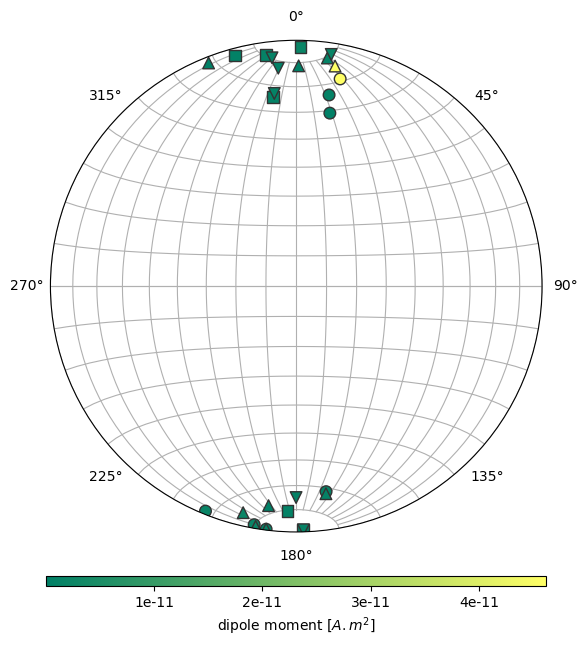

In [31]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(teste)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [32]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(all_positions))[1]
z_difference = all_positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.74203357,  0.20500167,  0.40009803,  0.30562587,  0.16723547,
       -0.00709327,  0.68957887,  0.41068558,  0.11329131,  0.32766291,
        0.29878292,  0.12986622, -0.16159292])

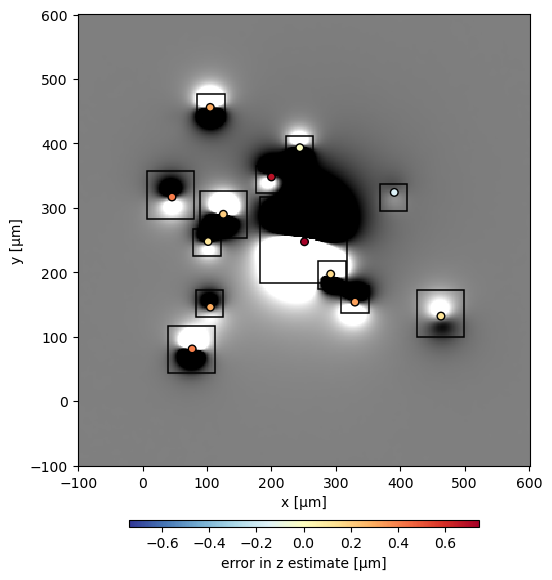

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*all_positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [34]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(teste, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 14.932235314166583 ± 0.112
Declination: 10.0 | 11.963674368998797 ± 0.159
Amplitude  : 5.000000e-11 | 4.621725e-11 ± 1.2e-13
R²   : 0.97051 
SNR  : 15.31306 
Direction Misfit  : 5.29° 
Magnetic Moment Misfit  : 7.57 %

Inclination: 0.9815597208941573 | 1.6603786394206312 ± 0.114
Declination: -170.40097014953832 | -169.99908059897717 ± 0.161
Amplitude  : 1.911519e-12 | 1.858808e-12 ± 5.2e-15
R²   : 0.98935 
SNR  : 19.80251 
Direction Misfit  : 0.79° 
Magnetic Moment Misfit  : 2.76 %

Inclination: 0.5082551779939194 | 0.4116105384794647 ± 0.050
Declination: -172.92622171639294 | -172.93213012145097 ± 0.071
Amplitude  : 1.326680e-12 | 1.238916e-12 ± 1.5e-15
R²   : 0.99793 
SNR  : 26.85861 
Direction Misfit  : 0.10° 
Magnetic Moment Misfit  : 6.62 %

Inclination: -0.9792030225966605 | -0.7295641056194492 ± 0.030
Declination: 178.3075852641996 | 178.37795365983035 ± 0.044
Amplitude  : 1.327175e-12 | 1.270678e-12 ± 9.9e-16
R²   : 0.99974 
SNR  : 35.79995 
Direction Misfit

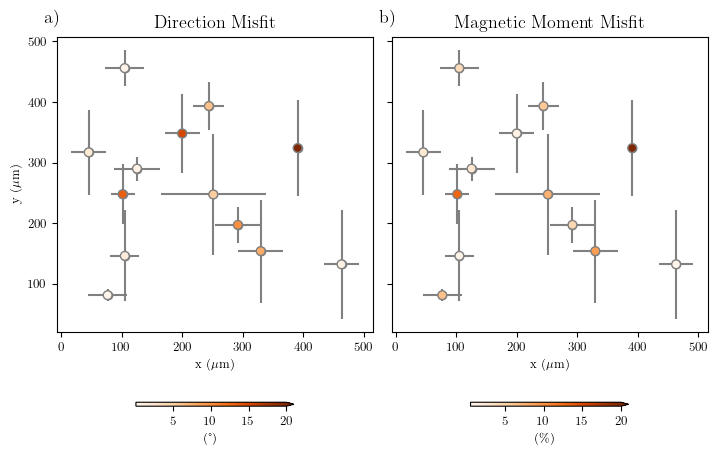

In [35]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(teste)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
        
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    

    plt.show()


### Show the observed and predicted data

In [36]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data.z], all_positions, teste)
residuo = data.bz.values - predicted_data

In [37]:
data = data.assign(predicted_data=(['y','x'],predicted_data))
data.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data.bz.values - data.predicted_data.values

data = data.assign(error=(['y','x'],error))
data.error.attrs = {"long_name": "residual-data", "units": "nT"}



In [38]:
data

<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 16.53 -50.71 38.8 ... -62.61 -32.4 -21.65
    predicted_data  (y, x) float64 4.729 4.75 4.771 4.792 ... 15.1 14.95 14.8
    error           (y, x) float64 11.8 -55.46 34.03 ... -77.7 -47.35 -36.44

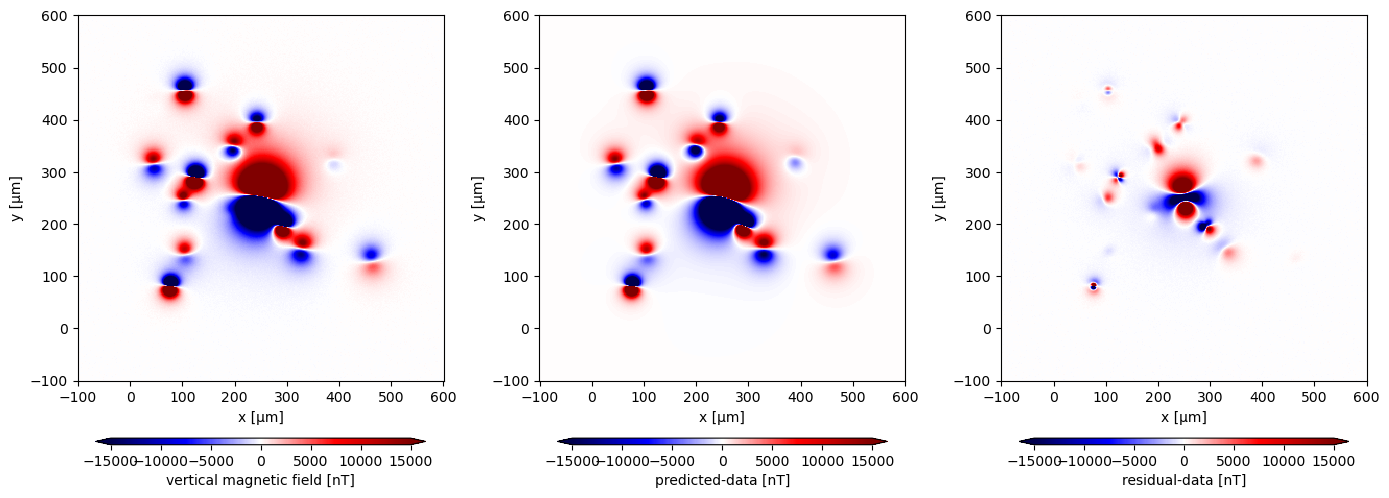

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +15000
    vmin = -15000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 5 windows

0
All modeled sources: R2 = 0.9768399959602863 and SNR = 16.379664255873845


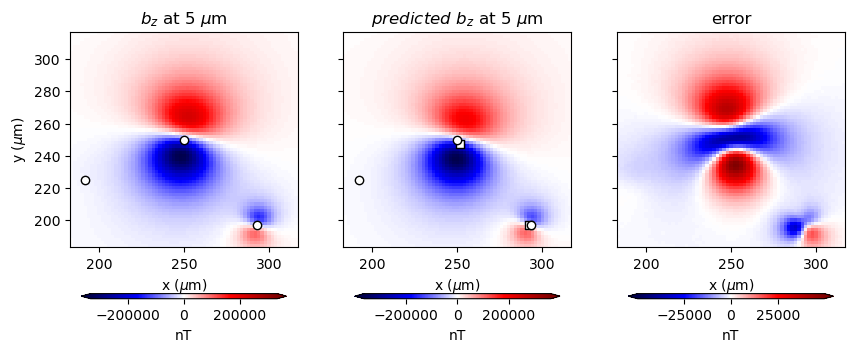

1
All modeled sources: R2 = 0.9964536165174774 and SNR = 24.51961529034014


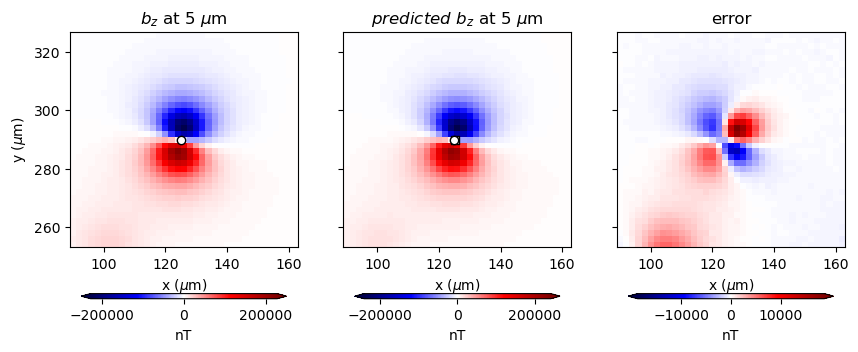

2
All modeled sources: R2 = 0.9936921122850915 and SNR = 22.001834593661297


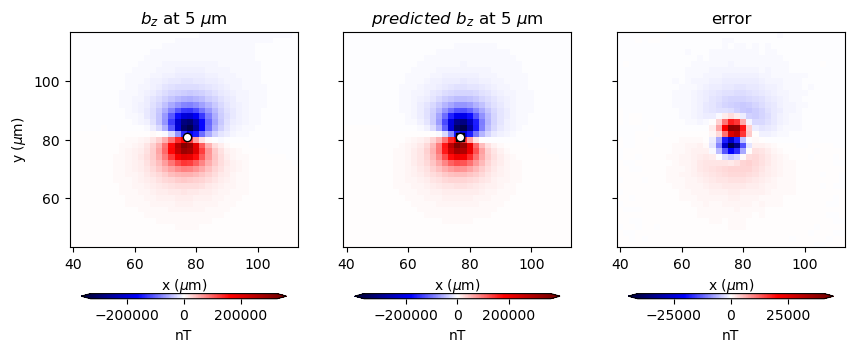

3
All modeled sources: R2 = 0.9990295246291987 and SNR = 30.147127551239766


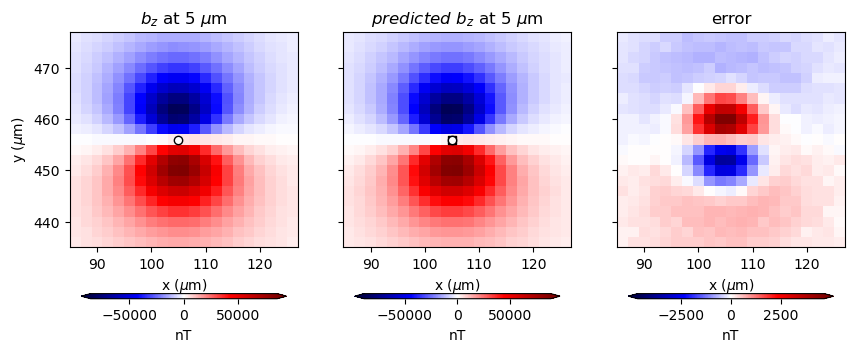

4
All modeled sources: R2 = 0.9635948952871732 and SNR = 14.784414836615653


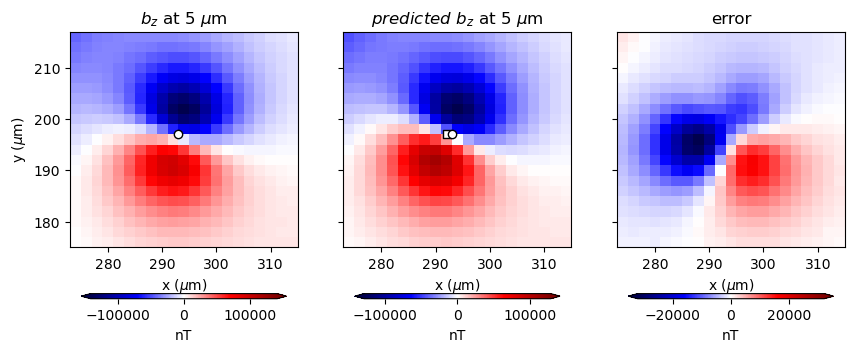

5
All modeled sources: R2 = 0.9761796461481533 and SNR = 17.034161868872598


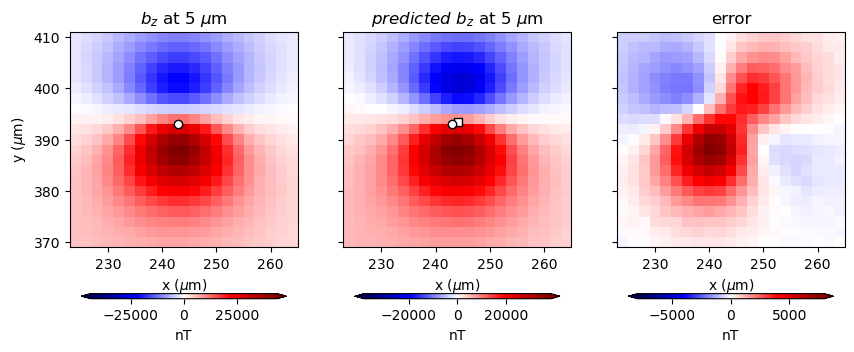

6
All modeled sources: R2 = 0.7673732331089145 and SNR = 8.813265233711169


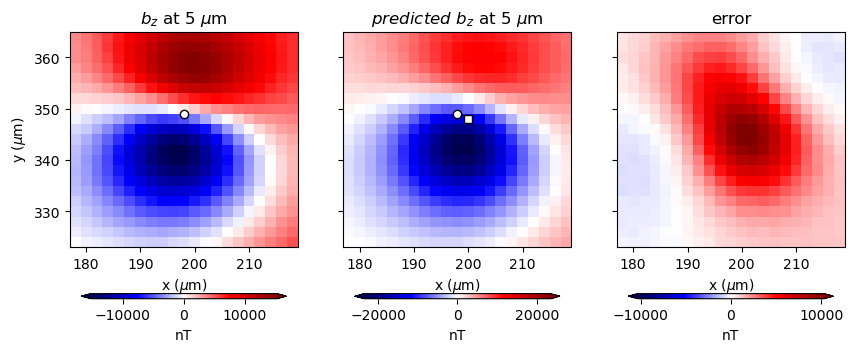

7
All modeled sources: R2 = 0.9970945913586123 and SNR = 25.370784843681236


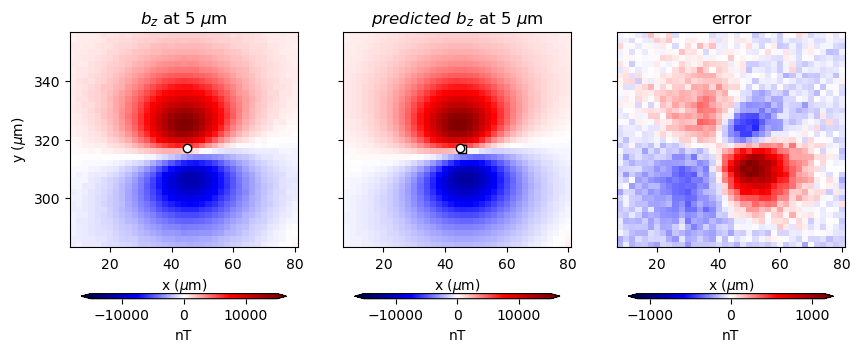

8
All modeled sources: R2 = 0.9327750877546122 and SNR = 12.324499177170338


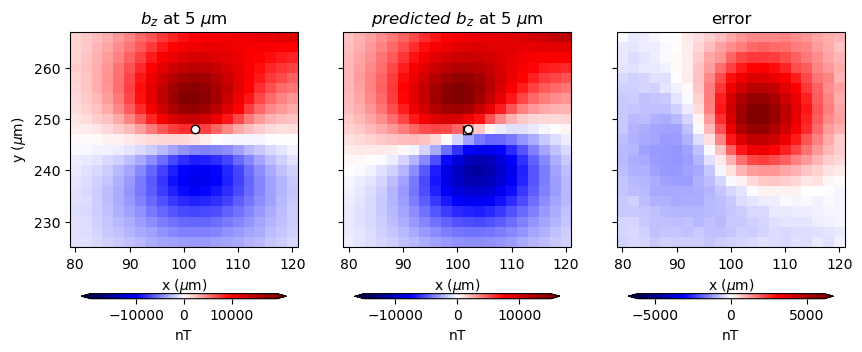

9
All modeled sources: R2 = 0.9649366473504554 and SNR = 14.573048651505506


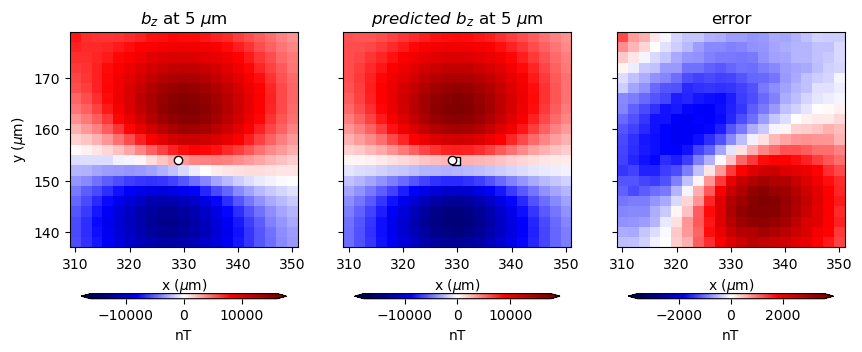

10
All modeled sources: R2 = 0.9928687259717327 and SNR = 24.79264510543024


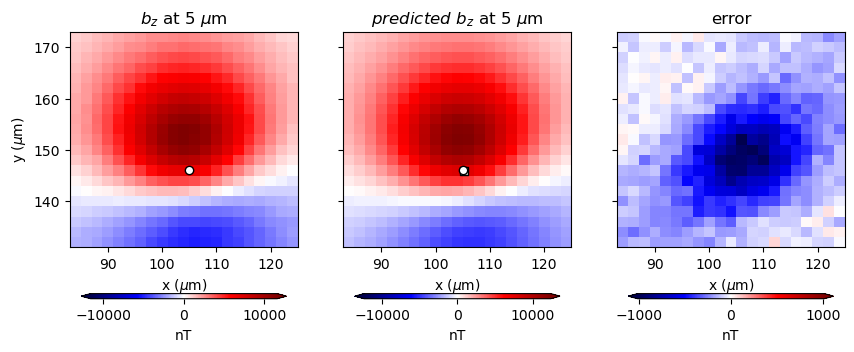

11
All modeled sources: R2 = 0.9986741998905985 and SNR = 28.780135381899324


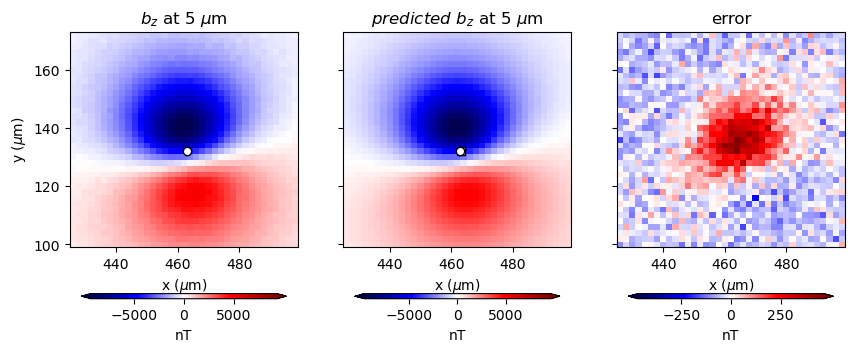

12
All modeled sources: R2 = -1.2409229565211963 and SNR = -0.31026215453967876


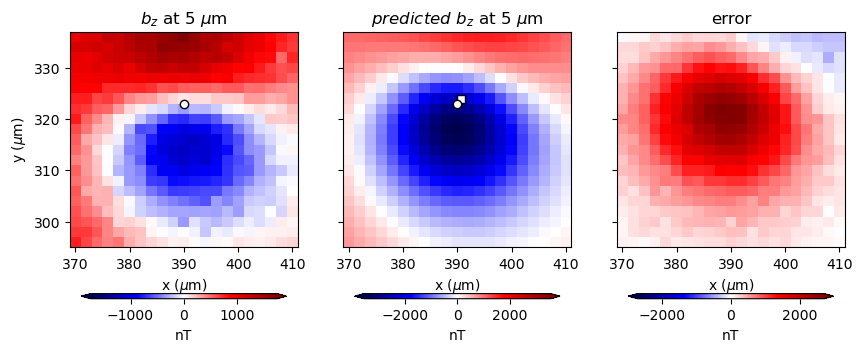

In [40]:
i = 0
for window in (windows_filtered):
    print(i)
    i += 1
    
    local_data = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(all_positions[0], all_positions[1], color='w', marker='s', edgecolors='k')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))

    plt.show()

# SIMPLEX

In [41]:
# chute inicial para moemntos de dipolo
guess_dipole_moments = all_dipole_moment_inversion(df, all_positions)

inc_guess, dec_guess, amp_guess = mg.vector_to_angles(guess_dipole_moments)
# cria o vetor de chute inicial
initial_guess = []
for xc, yc, zc in zip(all_positions[0], 
                      all_positions[1], 
                      all_positions[2]):
    for i in (xc, yc, zc):
        initial_guess.append(i)

# print(initial_guess)


# define a função objetivo
def goal_function(x, coordinates, data, all_positions, df): # entrar INC E DEC
    
    variable = np.reshape(x, (int(len(x)/3),3) ) 
    
    xc  = variable.T[0]
    yc  = variable.T[1]
    zc  = variable.T[2]
    
    estimated_moments = all_dipole_moment_inversion(df, all_positions)
    

    mx = estimated_moments[:, 0]
    my = estimated_moments[:, 1]
    mz = estimated_moments[:, 2]
    
    
    model = (mg.dipole_bz(coordinates, np.array([xc, yc, zc]), np.array([mx, my, mz]).T ))

    residuals = (data.bz.values - model)/TESLA_TO_NANOTESLA
    e = np.linalg.norm(residuals)
    
#     alpha = np.sum(model*data.bz.values)/np.sum(data.bz.values**2)
#     e = np.sqrt(np.sum( (alpha*data.bz.values-model)**2) )

    return e

In [42]:
print(goal_function(initial_guess, coordinates, data, all_positions, df))

optimization = sp.optimize.minimize(goal_function, 
                                   initial_guess, 
                                   args=(coordinates, data, all_positions, df), 
                                   options={'return_all': False}, method='Powell',tol=1.0e-12)


0.0007037493752114616


In [43]:
print(optimization)
print()
print((optimization['x']))
print()
print(initial_guess)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.00042402332530942414
       x: [ 2.501e+02  2.489e+02 ...  3.185e+02 -2.387e+01]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-5.736e-07  8.162e-08 ...  1.040e-06 -3.368e-12]]
    nfev: 6610

[250.05033362 248.85015641 -19.43300611 125.00426316 290.05540859
  -3.90114668  76.99922194  80.99386475  -1.81221828 105.0009811
 456.02561212  -5.81063449 292.6552712  196.63033854  -5.83071937
 243.14224621 393.66593682  -7.61746402 197.57202208 346.54014492
 -13.68498822  45.10680498 316.75866497 -13.78370799 102.83418746
 246.94817022  -9.2355452  329.01071086 153.66448349 -17.72437833
 104.97317074 146.19416586 -14.97446808 462.99457068 132.16744334
 -18.08591918 390.54897842 318.48084882 -23.87281509]

[251.37778286048632, 247.346

In [44]:
est_simplex = np.copy(optimization['x'])
est_simplex = np.reshape(est_simplex,  (int(len(est_simplex)/3),3) )

In [45]:
xc_est_simplex = est_simplex[:, 0]
yc_est_simplex = est_simplex[:, 1]
zc_est_simplex = est_simplex[:, 2]


all_positions_simplex =  np.array([xc_est_simplex, yc_est_simplex, zc_est_simplex])
simplex_est_dipole_moments = all_dipole_moment_inversion(df, all_positions_simplex)

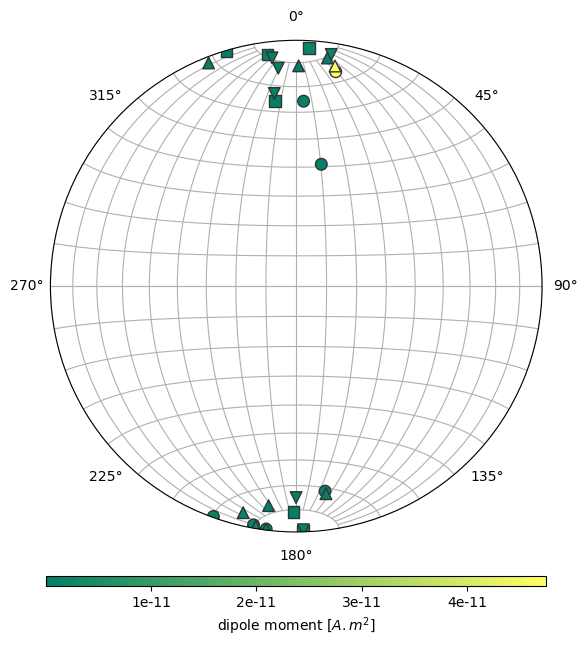

In [46]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(simplex_est_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

In [47]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(all_positions_simplex))[1]
z_difference = all_positions_simplex[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.56699389,  0.09885332,  0.18778172,  0.18936551,  0.16928063,
        0.38253598, -0.68498822,  0.21629201,  0.7644548 , -0.72437833,
        0.02553192, -0.08591918, -7.87281509])

In [48]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(simplex_est_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc}")
    print(f"Declination: {dec} | {edec}")
    print(f"Amplitude  : {amp:e} | {eamp:e}")

    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 12.344927929152208
Declination: 10.0 | 10.434981888417838
Amplitude  : 5.000000e-11 | 4.754836e-11
Direction Misfit  : 2.38° 
Magnetic Moment Misfit  : 4.90 %

Inclination: 0.9815597208941573 | 1.5058535657264616
Declination: -170.40097014953832 | -169.85843743364396
Amplitude  : 1.911519e-12 | 1.891351e-12
Direction Misfit  : 0.75° 
Magnetic Moment Misfit  : 1.06 %

Inclination: 0.5082551779939194 | 0.48583859074378744
Declination: -172.92622171639294 | -172.93789020957084
Amplitude  : 1.326680e-12 | 1.285297e-12
Direction Misfit  : 0.03° 
Magnetic Moment Misfit  : 3.12 %

Inclination: -0.9792030225966605 | -0.6402317933309435
Declination: 178.3075852641996 | 178.39028529987766
Amplitude  : 1.327175e-12 | 1.291304e-12
Direction Misfit  : 0.35° 
Magnetic Moment Misfit  : 2.70 %

Inclination: 5.978214795983371 | 0.4797899277179706
Declination: -166.80518094006803 | -160.21756886002777
Amplitude  : 1.846642e-12 | 1.769792e-12
Direction Misfit  : 8.57° 
Magnetic Moment

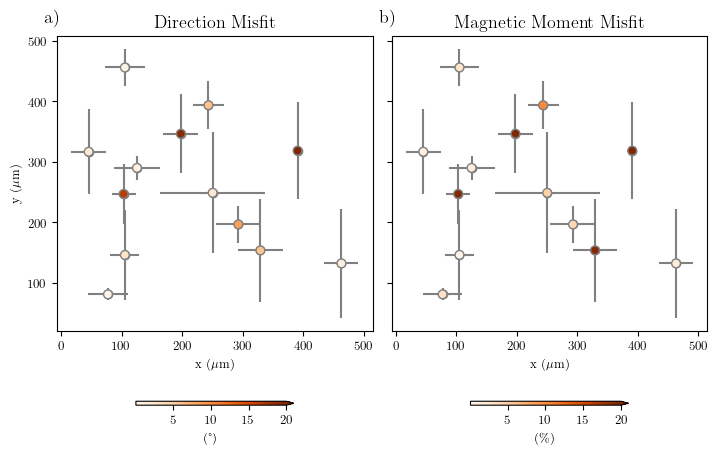

In [49]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(simplex_est_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*all_positions_simplex[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions_simplex[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*all_positions_simplex[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions_simplex[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    plt.show()


In [50]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data.z], all_positions_simplex, simplex_est_dipole_moments)
residuo = data.bz.values - predicted_data

data = data.assign(predicted_data=(['y','x'],predicted_data))
data.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data.bz.values - data.predicted_data.values

data = data.assign(error=(['y','x'],error))
data.error.attrs = {"long_name": "residual-data", "units": "nT"}

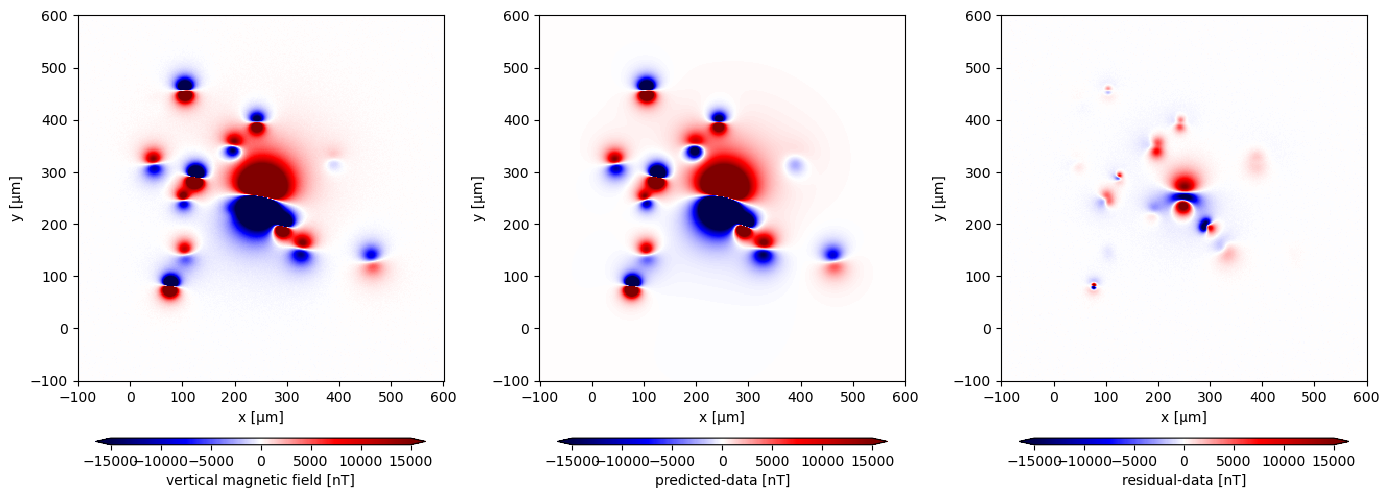

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = 15000
    vmin = -15000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

0
All modeled sources: R2 = 0.9951018105641132 and SNR = 23.110164490180495


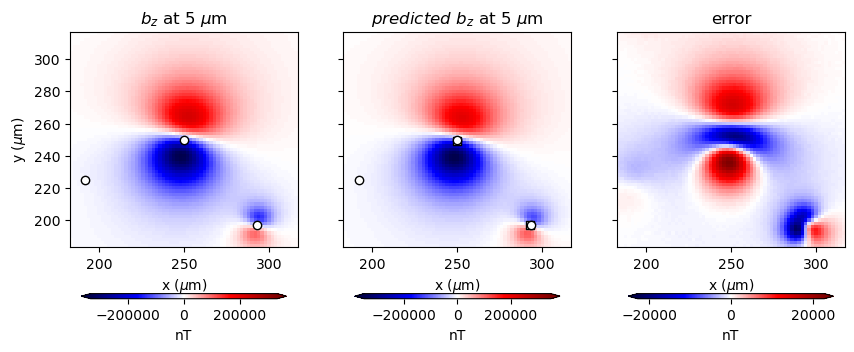

1
All modeled sources: R2 = 0.9991499885183955 and SNR = 30.856158584927563


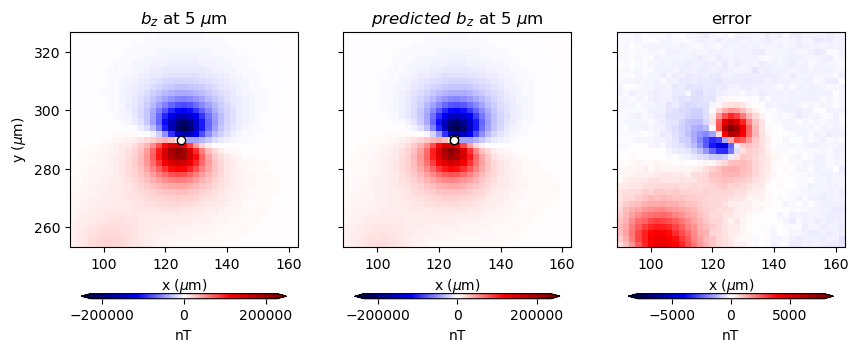

2
All modeled sources: R2 = 0.9987136086909653 and SNR = 28.907081689531296


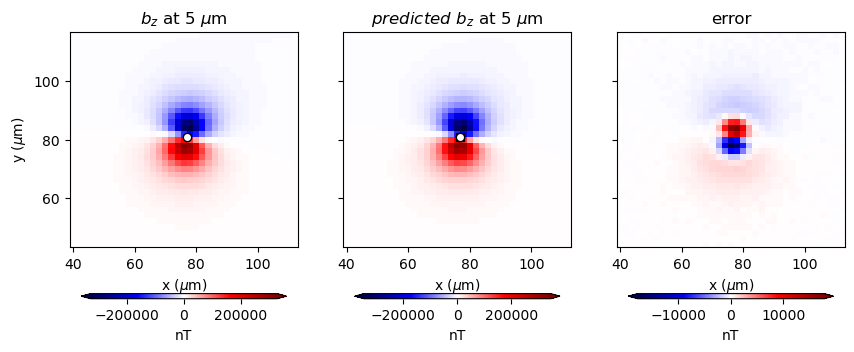

3
All modeled sources: R2 = 0.999622487130267 and SNR = 34.28519319624285


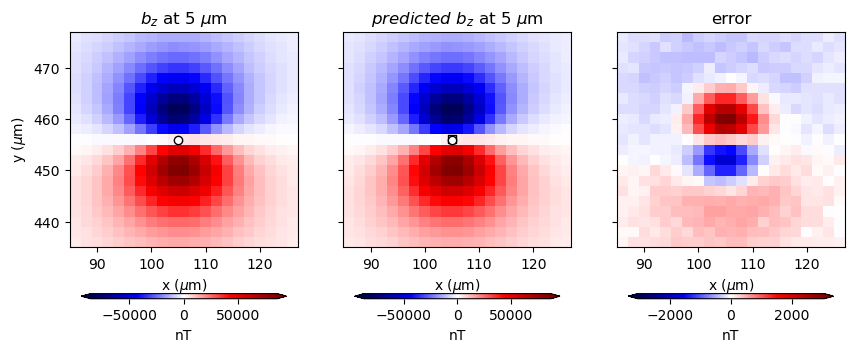

4
All modeled sources: R2 = 0.976989353331828 and SNR = 17.214680351518442


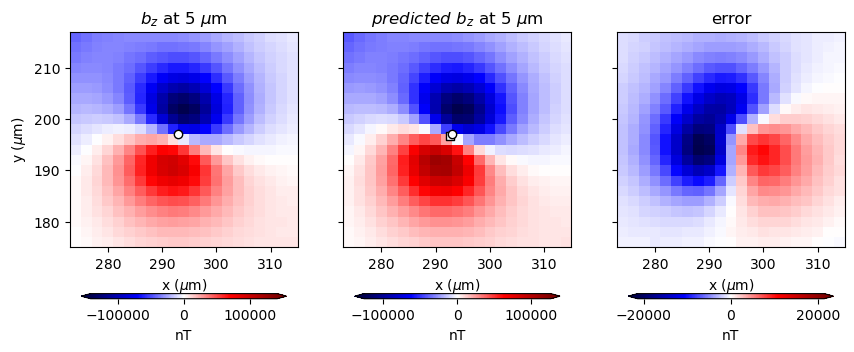

5
All modeled sources: R2 = 0.9855892486200769 and SNR = 20.065638129480874


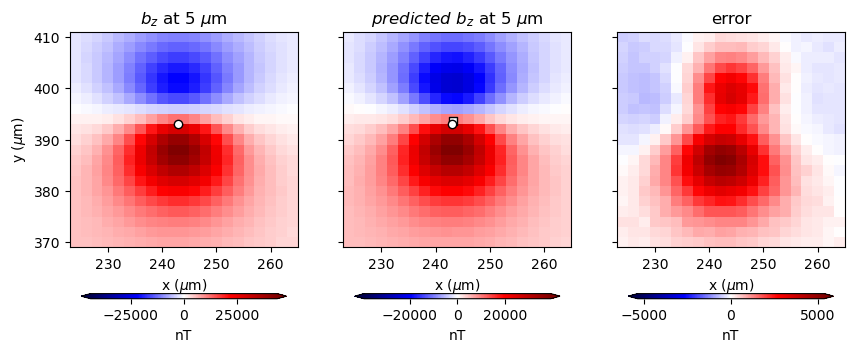

6
All modeled sources: R2 = 0.7858679201879489 and SNR = 10.573610043119821


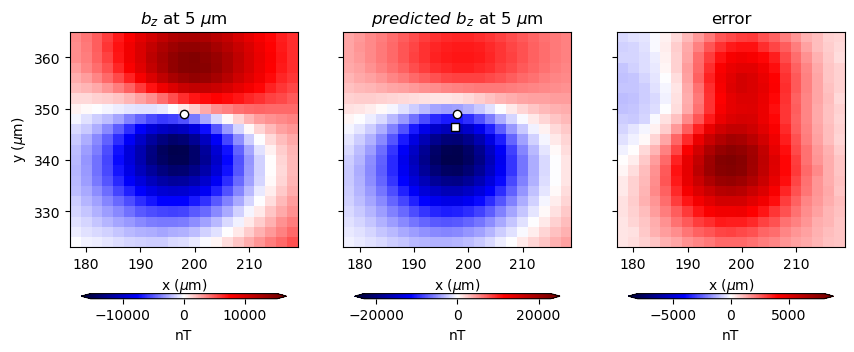

7
All modeled sources: R2 = 0.9987949562814501 and SNR = 29.222109938868858


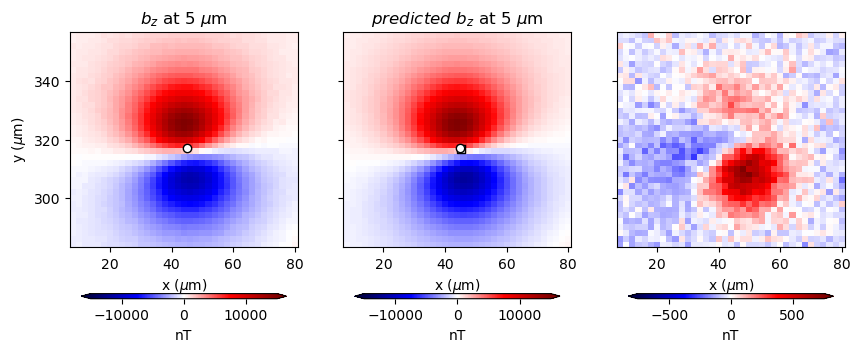

8
All modeled sources: R2 = 0.9297654941804604 and SNR = 12.232459579266974


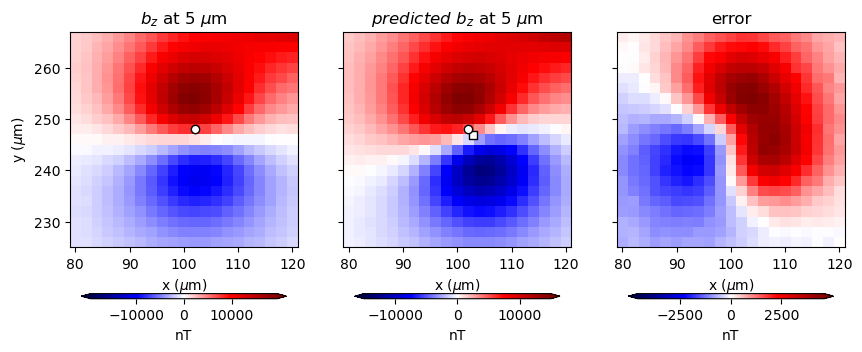

9
All modeled sources: R2 = 0.9819762293118058 and SNR = 17.454289770313434


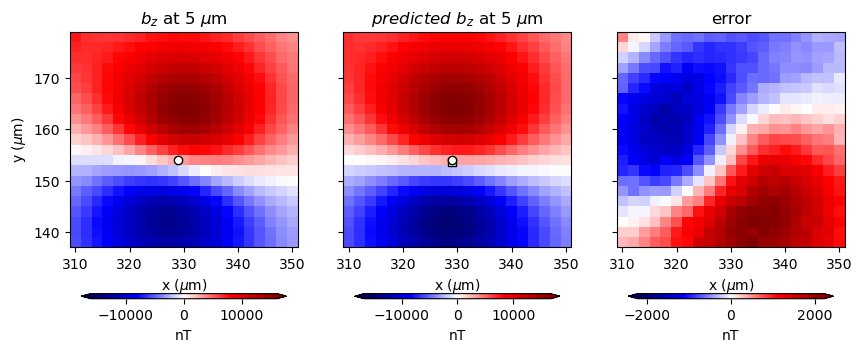

10
All modeled sources: R2 = 0.9932933160321387 and SNR = 26.3509351529081


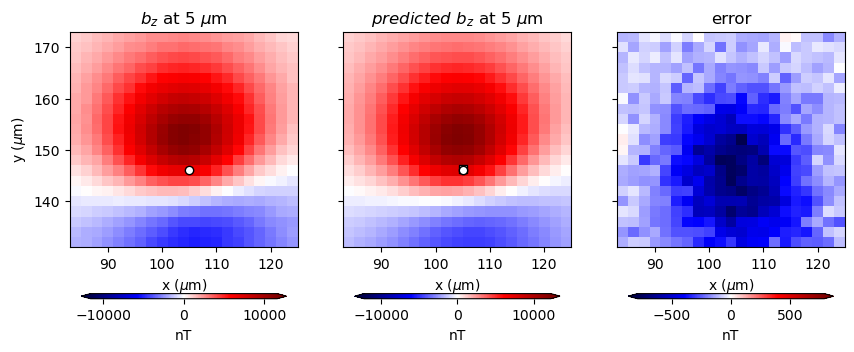

11
All modeled sources: R2 = 0.9992361338235133 and SNR = 31.64451189886002


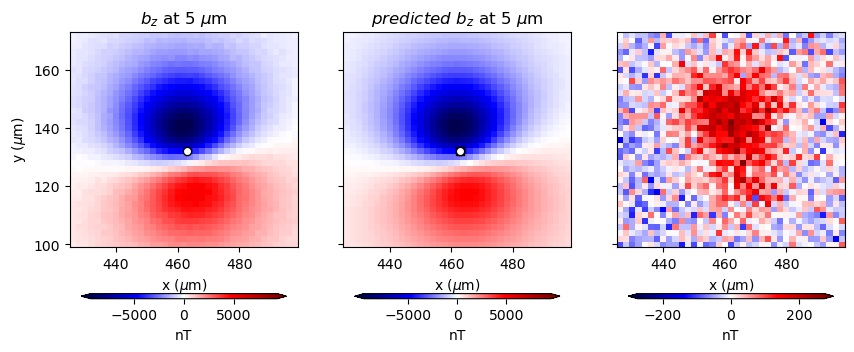

12
All modeled sources: R2 = -0.9600237387252633 and SNR = 6.437007273967069


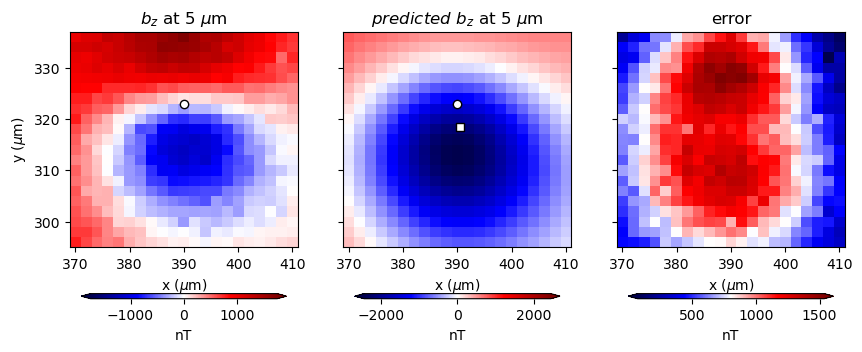

In [52]:
i = 0
for window in (windows):
    print(i)
    i += 1
    
    local_data = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(all_positions_simplex[0], all_positions_simplex[1], color='w', marker='s', edgecolors='k')
    
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))

    plt.show()

In [53]:
print(dipole_coordinates[2][closest])
print(zc_est_simplex)
print(all_positions[2])

print()

print(dipole_coordinates[0][closest])
print(xc_est_simplex)
print(all_positions[0])

print()

print(dipole_coordinates[1][closest])
print(yc_est_simplex)
print(all_positions[1])

[-20  -4  -2  -6  -6  -8 -13 -14 -10 -17 -15 -18 -16]
[-19.43300611  -3.90114668  -1.81221828  -5.81063449  -5.83071937
  -7.61746402 -13.68498822 -13.78370799  -9.2355452  -17.72437833
 -14.97446808 -18.08591918 -23.87281509]
[-19.25796643  -3.79499833  -1.59990197  -5.69437413  -5.83276453
  -8.00709327 -12.31042113 -13.58931442  -9.88670869 -16.67233709
 -14.70121708 -17.87013378 -16.16159292]

[250 125  77 105 293 243 198  45 102 329 105 463 390]
[250.05033362 125.00426316  76.99922194 105.0009811  292.6552712
 243.14224621 197.57202208  45.10680498 102.83418746 329.01071086
 104.97317074 462.99457068 390.54897842]
[251.37778286 125.36618447  76.93930914 104.99481711 292.01787545
 244.14842208 199.96017923  45.62357504 101.68358938 329.70635053
 105.28220983 463.19413222 390.74975647]

[250 290  81 456 197 393 349 317 248 154 146 132 323]
[248.85015641 290.05540859  80.99386475 456.02561212 196.63033854
 393.66593682 346.54014492 316.75866497 246.94817022 153.66448349
 146.19416586

In [54]:
data_up

<xarray.Dataset>
Dimensions:        (y: 351, x: 351)
Coordinates:
  * y              (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * x              (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z              (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz             (y, x) float64 8.119 8.97 9.577 8.5 ... 4.358 5.318 6.993
    tga            (y, x) float64 0.5436 0.505 1.164 1.305 ... 1.69 1.264 0.8729
    x_deriv        (y, x) float64 0.4255 0.3645 -0.1177 ... 0.1309 0.6587 0.8375
    y_deriv        (y, x) float64 -0.276 -0.3295 -0.3389 ... -0.1729 0.03741
    z_deriv        (y, x) float64 -0.1957 -0.1164 -1.107 ... 1.587 1.065 0.2431
    tga_stretched  (y, x) float64 5.003e-05 4.142e-05 ... 0.0002104 0.0001233

In [55]:
data

<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 16.53 -50.71 38.8 ... -62.61 -32.4 -21.65
    predicted_data  (y, x) float64 3.266 3.273 3.28 3.287 ... 14.4 14.26 14.11
    error           (y, x) float64 13.26 -53.99 35.52 ... -77.01 -46.66 -35.76

In [56]:
data = data.assign(mg.data_gradients(data.bz))
data

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 16.53 -50.71 38.8 ... -62.61 -32.4 -21.65
    predicted_data  (y, x) float64 3.266 3.273 3.28 3.287 ... 14.4 14.26 14.11
    error           (y, x) float64 13.26 -53.99 35.52 ... -77.01 -46.66 -35.76
    tga             (y, x) float64 42.97 183.7 81.11 34.21 ... 36.94 92.55 198.1
    x_deriv         (y, x) float64 -33.62 5.567 24.75 ... -25.38 10.24 5.38
    y_deriv         (y, x) float64 13.55 11.73 1.584 ... 5.002 -34.29 -25.61
    z_deriv         (y, x) float64 23.08 183.2 -77.22 ... 26.36 85.35 196.4